### Initial data analysis
Before making a selection which models to employ and what features to consider it is a good idea to take a closer look at the data that we'll be working with. The structure of the data could give us some insights as to which tools that are likely to give us the greatest success in attempting to classify songs as liked or disliked.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import seaborn as sns
sns.set_style("dark")

In [2]:
# Load dataset and preview
df = pd.read_csv("project_train.csv")
df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Label
0,0.545,0.884,5,-4.807,0,0.367,0.290000,0.000000,0.370,0.641,86.049,1
1,0.795,0.545,7,-8.153,1,0.343,0.003960,0.000000,0.273,0.809,91.967,1
2,0.489,0.871,5,-5.825,1,0.386,0.002850,0.000004,0.130,0.341,117.431,1
3,0.539,0.931,4,-1.803,0,0.262,0.000713,0.000000,0.204,0.685,85.571,0
4,0.918,0.734,11,-2.832,0,0.269,0.029400,0.000008,0.191,0.608,97.044,1


After loading the data into dataframes and normalizing we'll now partition the dataset into two datasets; liked songs and disliked songs.

In [3]:
# Split data into liked vs disliked
df_liked = df[df['Label'] == 1].drop('Label', axis = 1)
df_disliked = df[df['Label'] == 0].drop('Label', axis = 1)

# Normalize data
df_liked = (df_liked - df_liked.min()) / (df_liked.max() - df_liked.min())
df_disliked = (df_disliked - df_disliked.min()) / (df_disliked.max() - df_disliked.min())

## Identifying distinguishing features for music that is liked vs disliked
One way of visualizing the feature importance is to plot a radar chart.
After the features has been normalized, the means are calculated for each feature for the two datasets, in order to produce the radar chart below.

In [4]:
# Calculate means of features across songs that are liked vs not liked
labels = np.array(df_liked.columns)
feature_means_liked = df_liked.mean()
feature_means_disliked = df_disliked.mean()

# View features in radar chart
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=np.append(feature_means_liked.values, feature_means_liked.values[0]),
      theta=np.append(labels, labels[0]),
      fill='toself',
      name='Liked songs'
))
fig.add_trace(go.Scatterpolar(
      r=np.append(feature_means_disliked.values, feature_means_disliked.values[0]),
      theta=np.append(labels, labels[0]),
      fill='toself',
      name='Disliked songs'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  showlegend=True
)
fig.show()

The graph above seems to indicate that `energy` seems to be a very distinguishing feature. In this particular case, a song which is considered to have a lot of `energy` is highly probable of being disliked.

## Investigating possible multicollinearity among features in the dataset
Now we'll check for covariance among the features. When considering which features to classify by or construct a model with, it may be helpful to be aware of any correlation that exists between features, since the model may suffer from multicollinearity.

If two or more features are highly correlated then they are essentially containing the same information about some dependent variable, thus one or more features may be considered to be redundant. Multicollinearity may lead to stability issues as well as the risk of overfitting the model to the training data.

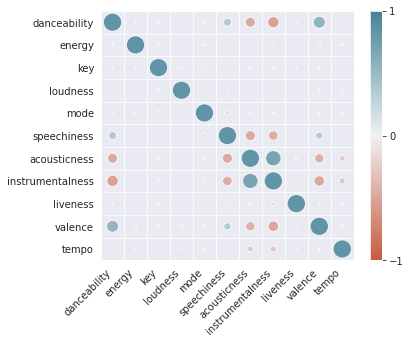

In [5]:
def corrplot(corr, labels):
    palette = sns.diverging_palette(20, 220, n = 256, as_cmap = True)
    N = len(labels)
    x, y = np.meshgrid(np.arange(N), np.arange(N))

    fig, ax = plt.subplots()

    circles = [plt.Circle((j,i), radius = r*0.4) for r, j, i in zip(corr.abs(), x.flat, y.flat)]
    col = PatchCollection(circles, array = corr, cmap = palette, alpha = 0.8)
    ax.add_collection(col)

    ax.set(xticks = np.arange(N), yticks = np.arange(N),
        xticklabels = labels, yticklabels = labels)
    ax.set_xticks(np.arange(N+1)-0.5, minor = True)
    ax.set_yticks(np.arange(N+1)-0.5, minor = True)
    ax.grid(which = 'minor')
    ax.invert_yaxis()
    fig.tight_layout()
    col.set_clim(-1,1)
    fig.colorbar(col, ticks = [-1, 0, 1])
    plt.setp(ax.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
    plt.show()

corr = df_liked.corr()
corr = pd.melt(corr.reset_index(), id_vars = 'index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
corrplot(corr = corr['value'], labels = labels)

In this case, if we were to base our future model on both the features `acousticness` and `instrumentalness` we would have to be careful since those features seem to be highly correlated.